# BankNifty Index Analysis and Risk Optimisation using HMM + Portfolio and its Comparative Analysis + Index Price Prediction 

### Installing dependencies

In [126]:

!pip install yfinance numpy pandas matplotlib hmmlearn keras tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.7/252.7 MB 2.3 MB/s eta 0:00:0000:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 5.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 5.8 MB/s eta 0:00:00a 0:00:01m


In [102]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM

print("All libraries loaded successfully!")

All libraries loaded successfully!


### lets select an index ( banknifty for eg)

In [105]:

index_symbol = "^NSEBANK"  # Bank Nifty index symbol on Yahoo Finance
banknifty_data = yf.download(index_symbol, start="2000-01-01", interval="1d")

print(f"Fetched {len(banknifty_data)} rows of data.")
print(banknifty_data.head())
print(banknifty_data.tail())


[*********************100%***********************]  1 of 1 completed

Fetched 4032 rows of data.
Price             Close         High          Low         Open   Volume
Ticker         ^NSEBANK     ^NSEBANK     ^NSEBANK     ^NSEBANK ^NSEBANK
Date                                                                   
2007-09-17  6897.020020  6977.119187  6842.920550  6897.919911        0
2007-09-18  7059.567871  7078.867940  6883.520112  6921.069480        0
2007-09-19  7401.764160  7419.263957  7110.917439  7110.917439        0
2007-09-20  7390.063965  7462.813119  7343.514701  7404.864086        0
2007-09-21  7464.413086  7506.262696  7367.064122  7378.213894        0
Price              Close          High           Low          Open   Volume
Ticker          ^NSEBANK      ^NSEBANK      ^NSEBANK      ^NSEBANK ^NSEBANK
Date                                                                       
2025-04-03  51597.351562  51661.601562  50906.648438  50910.000000   291200
2025-04-04  51502.699219  51893.601562  51360.398438  51711.601562   189600
2025-04-07  49860

### lets get the returns dataset of banknifty and prepare that data for HMM


In [107]:
banknifty_data['Returns'] = banknifty_data['Close'].pct_change() * 100
banknifty_data = banknifty_data.dropna()

observations = banknifty_data['Returns'].values.reshape(-1, 1)
print(observations[:5])

[[ 2.35678382]
 [ 4.84726962]
 [-0.15807306]
 [ 1.00606871]
 [ 2.49715479]]


### Building and training HMM (Gaussian)

In [159]:
model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
model.fit(observations)

hidden_states_pred = model.predict(observations)

state_means = [np.mean(observations[hidden_states_pred == i]) for i in range(3)]
sorted_states = np.argsort(state_means)  

state_map = {
    sorted_states[0]: 'Bearish',
    sorted_states[1]: 'Neutral',
    sorted_states[2]: 'Bullish'
}

predicted_states = [state_map[state] for state in hidden_states_pred]
banknifty_data['Predicted_State'] = predicted_states

print(banknifty_data[['Close', 'Returns', 'Predicted_State']].head())
print(banknifty_data[['Close', 'Returns', 'Predicted_State']].tail())


Price             Close   Returns Predicted_State
Ticker         ^NSEBANK                          
Date                                             
2007-09-18  7059.567871  2.356784         Neutral
2007-09-19  7401.764160  4.847270         Neutral
2007-09-20  7390.063965 -0.158073         Neutral
2007-09-21  7464.413086  1.006069         Neutral
2007-09-24  7650.811035  2.497155         Neutral
Price              Close   Returns Predicted_State
Ticker          ^NSEBANK                          
Date                                              
2025-04-03  51597.351562  0.485512         Bullish
2025-04-04  51502.699219 -0.183444         Bullish
2025-04-07  49860.101562 -3.189343         Bearish
2025-04-08  50511.000000  1.305449         Bearish
2025-04-09  50240.148438 -0.536223         Bearish


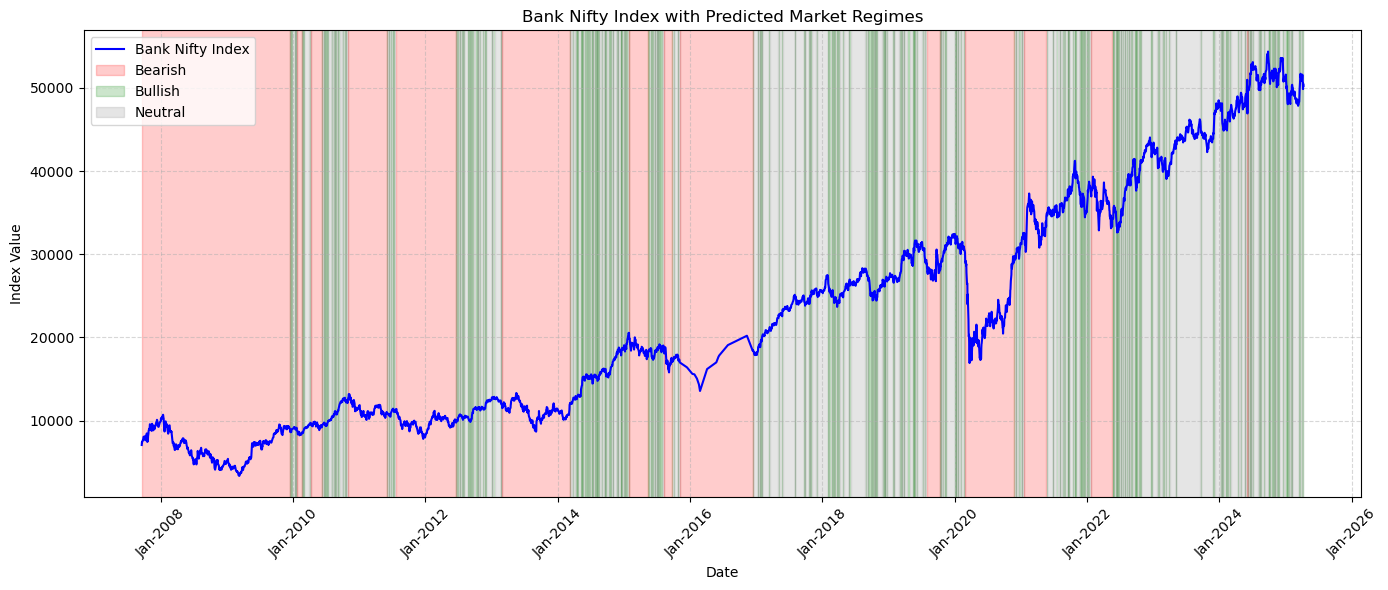

In [110]:
import matplotlib.dates as mdates
from itertools import groupby
from operator import itemgetter

plt.figure(figsize=(14, 6))
plt.plot(banknifty_data.index, banknifty_data['Close'], label='Bank Nifty Index', color='blue', linewidth=1.5)

state_colors = {'Bullish': 'green', 'Bearish': 'red', 'Neutral': 'gray'}

state_series = banknifty_data['Predicted_State'].values
date_series = banknifty_data.index.to_list()
groups = []

for k, g in groupby(enumerate(state_series), key=lambda x: x[1]):
    indices = list(map(itemgetter(0), g))
    start = date_series[indices[0]]
    end = date_series[indices[-1]]
    groups.append((start, end, k))

for start, end, state in groups:
    plt.axvspan(start, end, color=state_colors[state], alpha=0.2, label=state)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles)) 

plt.title('Bank Nifty Index with Predicted Market Regimes')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend(by_label.values(), by_label.keys(), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.tight_layout()
plt.show()


### Let’s optimize and improve this Bayesian risk visualization

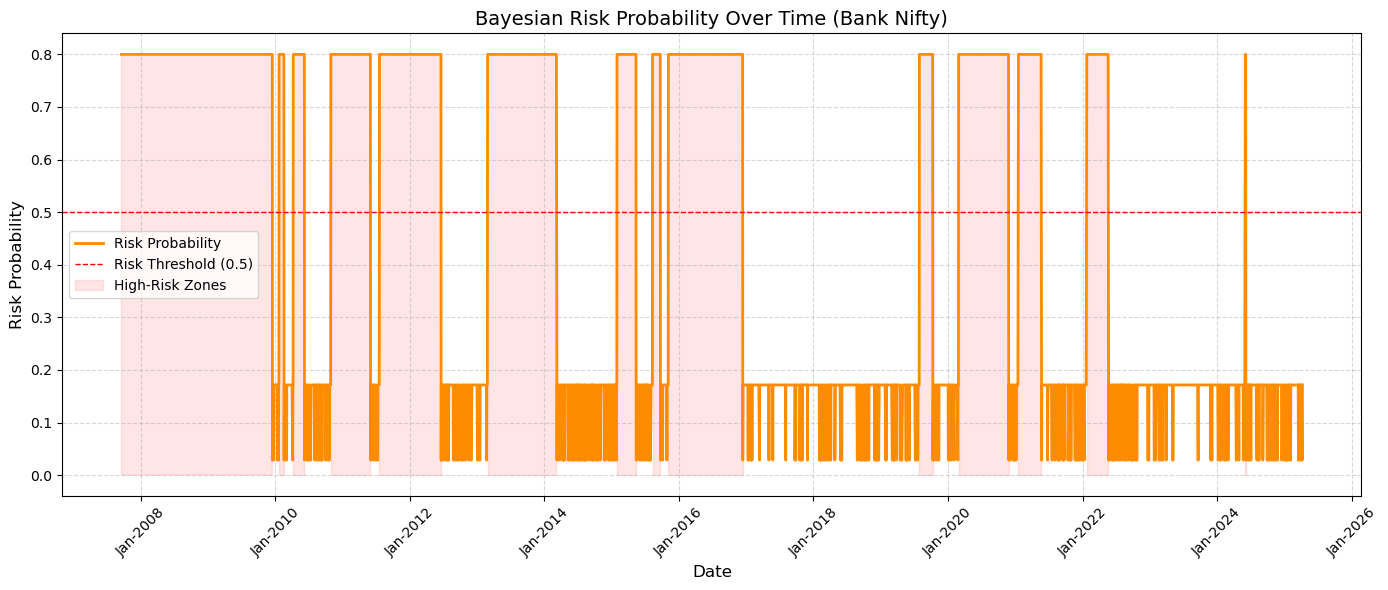

📊 Average Risk Probability: 0.43


In [112]:
import matplotlib.dates as mdates

prior_risk = {'Bullish': 0.1, 'Bearish': 0.7, 'Neutral': 0.3}
likelihood_drop = {'Bullish': 0.2, 'Bearish': 0.8, 'Neutral': 0.4}

def update_risk(state):
    prior = prior_risk[state]
    likelihood = likelihood_drop[state]
    evidence = sum(prior_risk[s] * likelihood_drop[s] for s in prior_risk)
    return (likelihood * prior) / evidence if evidence > 0 else prior

banknifty_data['Risk_Probability'] = banknifty_data['Predicted_State'].apply(update_risk)

plt.figure(figsize=(14, 6))
plt.plot(banknifty_data.index, banknifty_data['Risk_Probability'], label='Risk Probability', color='darkorange', linewidth=2)

plt.axhline(0.5, color='red', linestyle='--', linewidth=1, label='Risk Threshold (0.5)')

high_risk = banknifty_data['Risk_Probability'] > 0.5
plt.fill_between(banknifty_data.index, 0, banknifty_data['Risk_Probability'], 
                 where=high_risk, color='red', alpha=0.1, label='High-Risk Zones')


plt.title('Bayesian Risk Probability Over Time (Bank Nifty)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Risk Probability', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
plt.tight_layout()
plt.show()


print(f"📊 Average Risk Probability: {banknifty_data['Risk_Probability'].mean():.2f}")

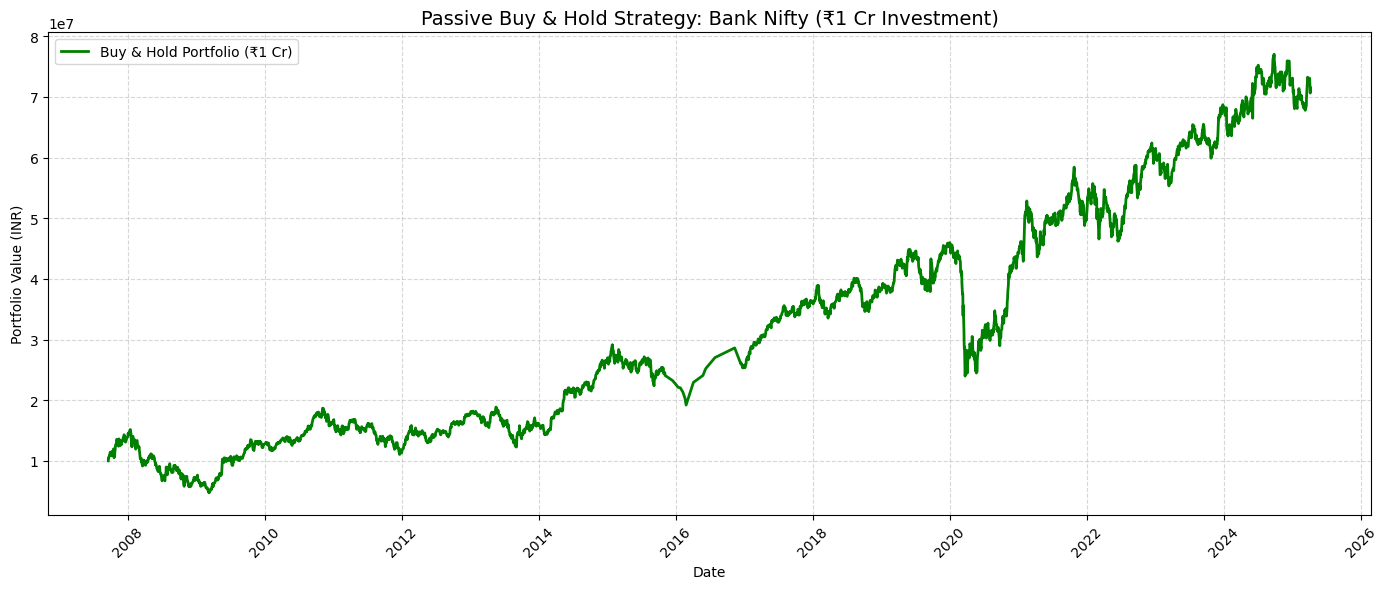

📈 Final Portfolio Value (Buy & Hold): ₹71,166,039.27
📊 Total Return: 611.66%


In [113]:
initial_passive_capital = 1_00_00_000  

initial_close = banknifty_data['Close'].iloc[0]
close_ratio = banknifty_data['Close'] / initial_close  # Growth multiplier

banknifty_data['BuyHold_Portfolio'] = initial_passive_capital * close_ratio

plt.figure(figsize=(14, 6))
plt.plot(banknifty_data.index, banknifty_data['BuyHold_Portfolio'], label='Buy & Hold Portfolio (₹1 Cr)', color='green', linewidth=2)
plt.title('Passive Buy & Hold Strategy: Bank Nifty (₹1 Cr Investment)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

final_value = banknifty_data['BuyHold_Portfolio'].iloc[-1]
print(f"📈 Final Portfolio Value (Buy & Hold): ₹{final_value:,.2f}")
print(f"📊 Total Return: {((final_value - initial_passive_capital) / initial_passive_capital) * 100:.2f}%")


In [114]:
investment_series = data['HMM_Investment'].squeeze() #Ensuring both are Series, not DataFrames
price_series = price_ratio.squeeze()

# same shape checking
assert investment_series.shape == price_series.shape, "Shape mismatch between investment and price series"
data['HMM_Portfolio_Value'] = (investment_series * price_series).cumsum()

In [116]:
print("Investment shape:", investment_series.shape)
print("Price Ratio shape:", price_series.shape)

Investment shape: (3473,)
Price Ratio shape: (3473,)


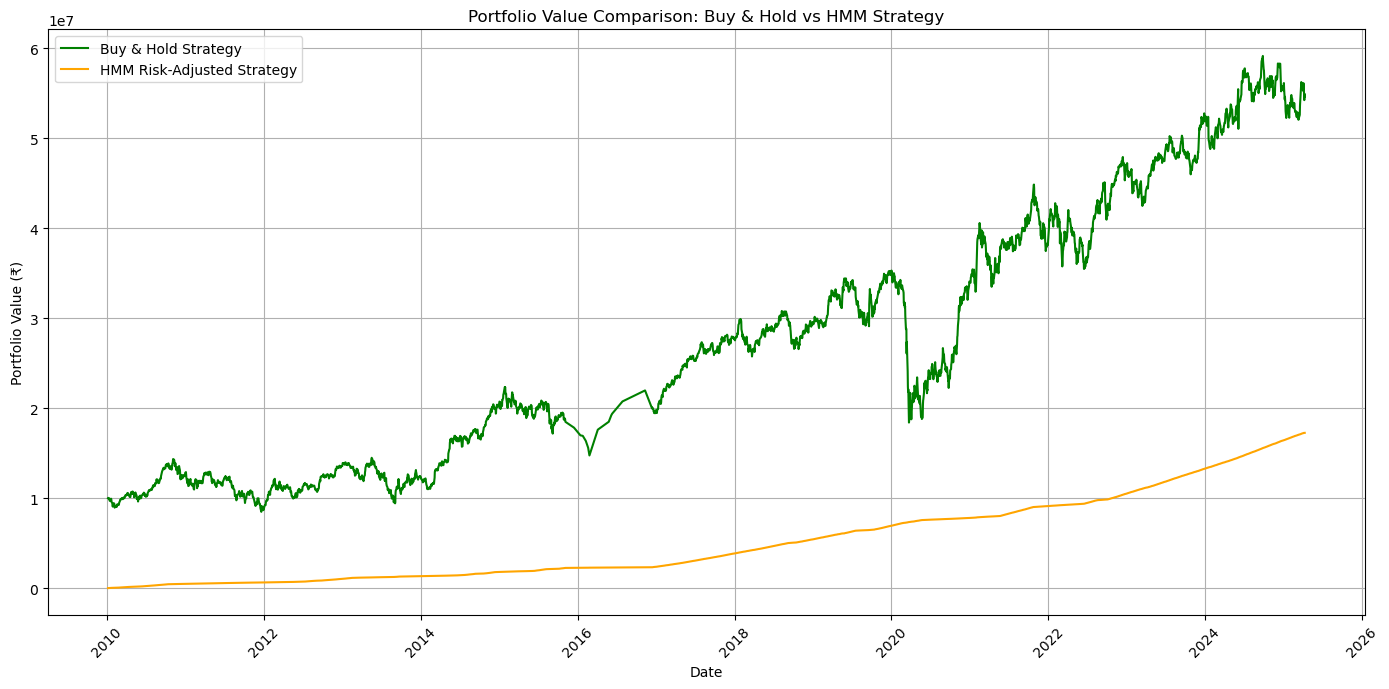

In [118]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['BuyHold_Portfolio_Value'], label='Buy & Hold Strategy', color='green')
plt.plot(data.index, data['HMM_Portfolio_Value'], label='HMM Risk-Adjusted Strategy', color='orange')
plt.title('Portfolio Value Comparison: Buy & Hold vs HMM Strategy')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Basic Portfolio Stats
initial_capital = 1e7
start_date = data.index[0]
end_date = data.index[-1]
num_years = (end_date - start_date).days / 365.25

# Helper functions
def calculate_cagr(start_val, end_val, years):
    return ((end_val / start_val) ** (1 / years)) - 1

def calculate_max_drawdown(series):
    roll_max = series.cummax()
    drawdown = (series - roll_max) / roll_max
    return drawdown.min()

def calculate_sharpe_ratio(returns, risk_free_rate=0.05):
    excess_returns = returns - risk_free_rate / 252  # daily excess return
    return np.sqrt(252) * excess_returns.mean() / excess_returns.std()

hmm_returns = data['HMM_Portfolio_Value'].pct_change().dropna()
buyhold_returns = data['BuyHold_Portfolio_Value'].pct_change().dropna()

portfolio_summary = {
    'Initial Investment (₹)': [initial_capital, initial_capital],
    'Final Value (₹)': [
        data['HMM_Portfolio_Value'].iloc[-1],
        data['BuyHold_Portfolio_Value'].iloc[-1]
    ],
    'Total Return (%)': [
        ((data['HMM_Portfolio_Value'].iloc[-1] / initial_capital) - 1) * 100,
        ((data['BuyHold_Portfolio_Value'].iloc[-1] / initial_capital) - 1) * 100
    ],
    'CAGR (%)': [
        calculate_cagr(initial_capital, data['HMM_Portfolio_Value'].iloc[-1], num_years) * 100,
        calculate_cagr(initial_capital, data['BuyHold_Portfolio_Value'].iloc[-1], num_years) * 100
    ],
    'Max Drawdown (%)': [
        calculate_max_drawdown(data['HMM_Portfolio_Value']) * 100,
        calculate_max_drawdown(data['BuyHold_Portfolio_Value']) * 100
    ],
    'Volatility (Daily Std Dev)': [
        hmm_returns.std(),
        buyhold_returns.std()
    ],
    'Sharpe Ratio': [
        calculate_sharpe_ratio(hmm_returns),
        calculate_sharpe_ratio(buyhold_returns)
    ]
}

summary_df = pd.DataFrame(portfolio_summary, index=['HMM Strategy', 'Buy & Hold'])

print("📊 Portfolio Performance Summary:\n")
display(summary_df.round(2))

summary_df.to_excel("Portfolio_Comparison.xlsx")

summary_df.to_csv("Portfolio_Comparison.csv")


📊 Portfolio Performance Summary:



,Initial Investment (₹),Final Value (₹),Total Return (%),CAGR (%),Max Drawdown (%),Volatility (Daily Std Dev),Sharpe Ratio
HMM Strategy,10000000.0,17259553.18,72.60,3.64,0.00,0.02,1.86
Buy & Hold,10000000.0,54656122.99,446.56,11.77,-47.86,0.02,0.42


## Drawdown Analysis

/var/folders/9v/r_2c7hc918n908nv5y3s81_m0000gn/T/ipykernel_17024/2090694891.py:19: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


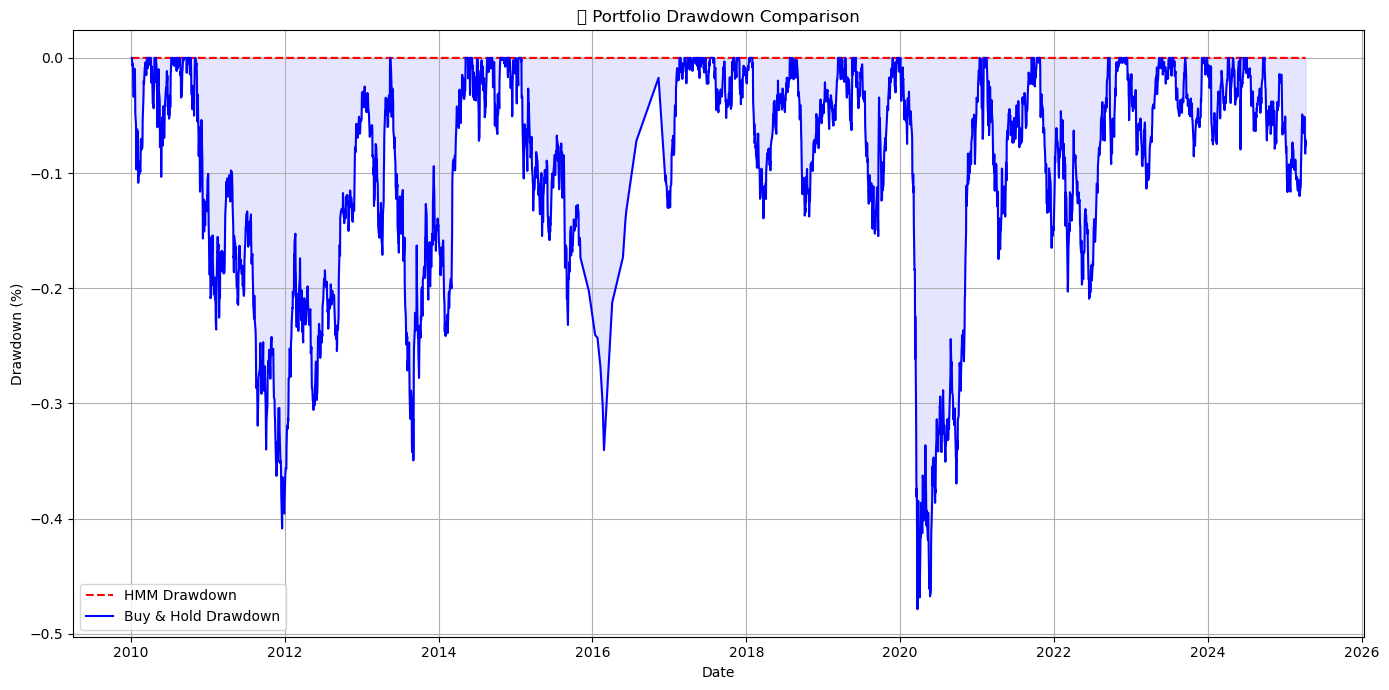

In [121]:
def compute_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown

hmm_drawdown = compute_drawdown(data['HMM_Portfolio_Value'])
buyhold_drawdown = compute_drawdown(data['BuyHold_Portfolio_Value'])

plt.figure(figsize=(14, 7))
plt.plot(hmm_drawdown, label='HMM Drawdown', color='red', linestyle='--')
plt.plot(buyhold_drawdown, label='Buy & Hold Drawdown', color='blue', linestyle='-')
plt.fill_between(hmm_drawdown.index, hmm_drawdown, color='red', alpha=0.1)
plt.fill_between(buyhold_drawdown.index, buyhold_drawdown, color='blue', alpha=0.1)
plt.title('📉 Portfolio Drawdown Comparison')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Lower spikes (more negative) = higher risk.

#smoother curve means the strategy handled volatility better.

## now lets try prediction

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load your Bank Nifty data — assume 'Date' is already set as index
data = banknifty_data.copy()
close_prices = data['Close'].values.reshape(-1, 1)

# Normalize close prices
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Split into training (80%) and test (20%) sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - 60:]  # Include last 60 for input window

# Create sequences
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data)
X_test, y_test = create_sequences(test_data)

# Reshape for LSTM [samples, time_steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


### Fetching last 60 days data and trying to plot prediction

In [137]:
# Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))

# Compile and train
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0200
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.5263e-04
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.1483e-04
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.4561e-04
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.2788e-04
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 2.2057e-04
Epoch 7/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 1.6750e-04
Epoch 8/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 1.9132e-04
Epoch 9/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.7387e-04
Epoch 10/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.6979e-04


In [139]:
# Predict next day price
last_60_days = scaled_data[-60:]
X_future = last_60_days.reshape(1, 60, 1)
predicted_price = lstm_model.predict(X_future)
predicted_price = scaler.inverse_transform(predicted_price)

print(f"📈 Predicted Next Day Bank Nifty Price: ₹{predicted_price[0][0]:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
📈 Predicted Next Day Bank Nifty Price: ₹50560.95


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


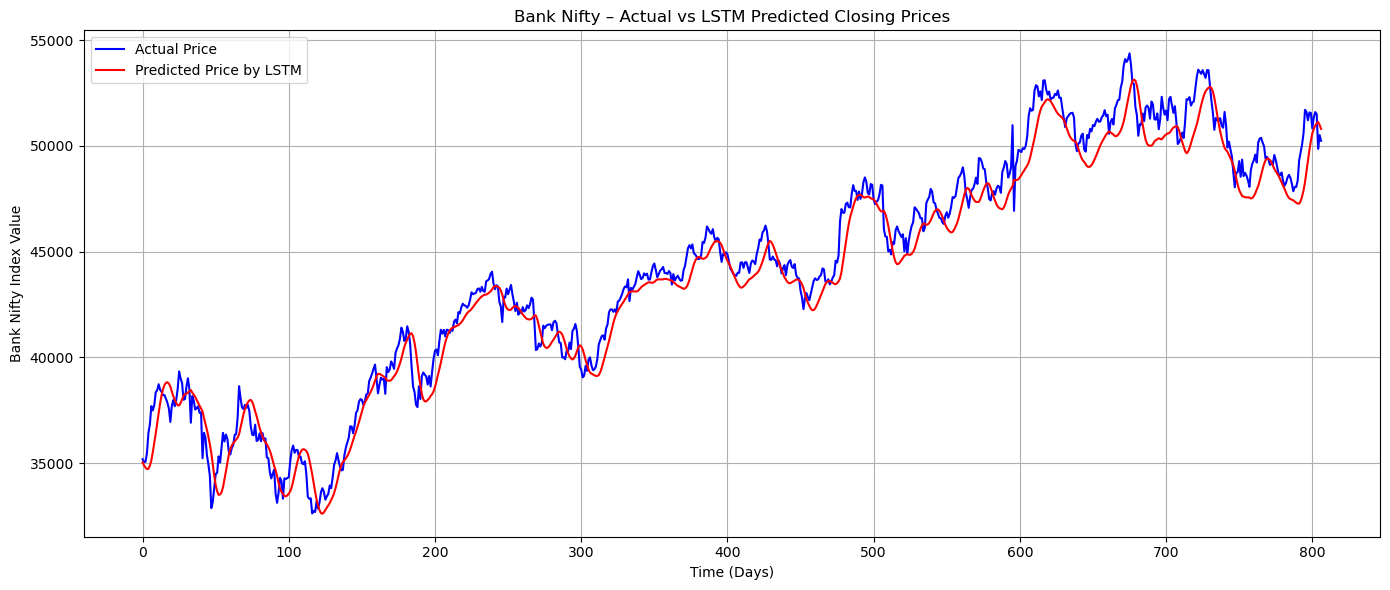

In [141]:
# Predict on test data
predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual y_test values
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price by LSTM', color='red')
plt.title('Bank Nifty – Actual vs LSTM Predicted Closing Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Bank Nifty Index Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [151]:
import yfinance as yf

df = yf.download("^NSEBANK", start="2015-01-01", end="2024-12-31")
df.reset_index(inplace=True)  # So you can access 'Date' as a column


[*********************100%***********************]  1 of 1 completed


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
          Date  Actual Price  Predicted Price
802 2024-12-23  51597.351562     50957.847656
803 2024-12-24  51502.699219     51070.789062
804 2024-12-26  49860.101562     51130.738281
805 2024-12-27  50511.000000     50987.683594
806 2024-12-30  50240.148438     50802.371094


Text(0.5, 1.0, 'Bank')

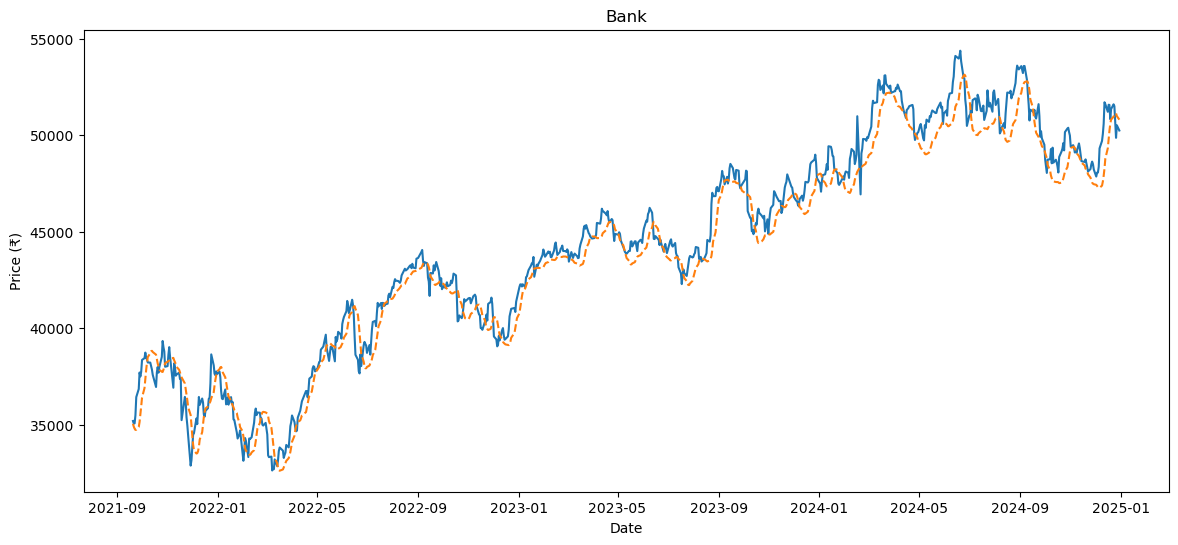

In [153]:
from datetime import timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


predicted_price = lstm_model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
actual_price = scaler.inverse_transform(y_test.reshape(-1, 1))


dates = df['Date'].iloc[-len(predicted_price):].reset_index(drop=True)
comparison_df = pd.DataFrame({
    'Date': dates,
    'Actual Price': actual_price.flatten(),
    'Predicted Price': predicted_price.flatten()
})

print(comparison_df.tail())

plt.figure(figsize=(14,6))
plt.plot(comparison_df['Date'], comparison_df['Actual Price'], label='Actual Price')
plt.plot(comparison_df['Date'], comparison_df['Predicted Price'], label='Predicted Price', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.title('Bank')


In [157]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

mae = mean_absolute_error(actual_price, predicted_price)
mse = mean_squared_error(actual_price, predicted_price)
rmse = np.sqrt(mse)
r2 = r2_score(actual_price, predicted_price)


metrics_df = pd.DataFrame({
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 
               'Root Mean Squared Error (RMSE)', 'R² Score'],
    'Value': [mae, mse, rmse, r2]
})

metrics_df['Value'] = metrics_df['Value'].apply(lambda x: f"{x:.4f}")

print(metrics_df.to_string(index=False))


                        Metric        Value
     Mean Absolute Error (MAE)     841.0942
      Mean Squared Error (MSE) 1081183.3646
Root Mean Squared Error (RMSE)    1039.7997
                      R² Score       0.9644
